# Analysis of side-view experiments or one-dimensional observational area


The following code is to analyze single-file movement experiments recorded using a side-view camera that captures the straight par of the oval setup or one-dimentional observational area setup recorded from side or top view.

The output of the analysis is the values of the movement quantities (Voronoi 1D density, individual instantaneous speed, and headway distance) and the plots of the following relations:
- Space-time diagrams
- Time-density/speed diagrams (transit, and steady states)
- Fundamental diagram (density-speed)
- Headway distance-speed diagrams

The aforementioned movement quantities (Voronoi 1D density, individual instantaneous speed, and headway distance) are calculated using the equations outlined in [Subaih et al.](10.1109/ACCESS.2020.2973917)

## Example: let us get started!


We will analyze the following single-file movement experiment: [Influence of gender in single-file movement](https://doi.org/10.34735/ped.2018.5), specifically the mixed-alternating gender experiments (N=14, N=20, N=24, and N=30).

<p align="center">
    <img src="demo_data/gender_subaih2020.png" alt="Alternative text"/>
</p>


> **NOTE:** The demo trajectory data are from the [Pedestrian Dynamics Data Archive](https://ped.fz-juelich.de/da/doku.php?id=start).

### Read the raw trajectories

First, we need to define the following arguments:
- ```path_traj_raw```: the path to the folder containing the raw trajectory data.
- ```files_traj_raw```: the names of the data files containing the raw trajectories.

In [1]:
path_traj_raw = (
    "../notebooks/demo_data/genderMixedAlternating_palestine_subaih2019/traj/00_raw"
)
files_traj_raw = ["UX_14_1.txt", "UX_20_1.txt", "UX_24_1.txt", "UX_30_1.txt"]

Next, we need to load the data into a Pandas DataFrame and print the raw trajectory data to check the data file format:

> **NOTE:** change the values of ```delimiter=...```, ```names=...```, and ```comment=...``` arguments based on the header names of the data files, or remove the arguments for .csv files.

> **NOTE:** there are different file formats and structures. Therefore, in all the following code blocks, the indexes of the Pandas data frames should be adjusted according to the column names from the loaded raw trajectory data.

In [2]:
import numpy as np
import pandas as pd

data_traj_raw = pd.read_csv(
    path_traj_raw + "/" + files_traj_raw[0],
    comment="#",
    delimiter="\t",
    names=["ID", "frame", "x(m)", "y(m)", "z(m)"],
)
print(data_traj_raw.head())

   ID  frame    x(m)    y(m)  z(m)
0   1      0  2.3473  1.5472   0.0
1   1      1  2.3719  1.5484   0.0
2   1      2  2.3968  1.5518   0.0
3   1      3  2.4195  1.5572   0.0
4   1      4  2.4430  1.5606   0.0


/tmp/ipykernel_1163515/2724814180.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Then, plot the trajectories of pedestrians using the (x,y) coordinates from the raw trajectory files. 

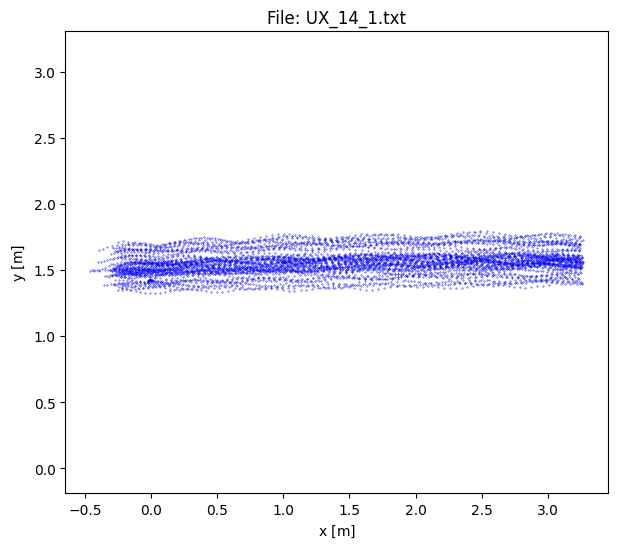

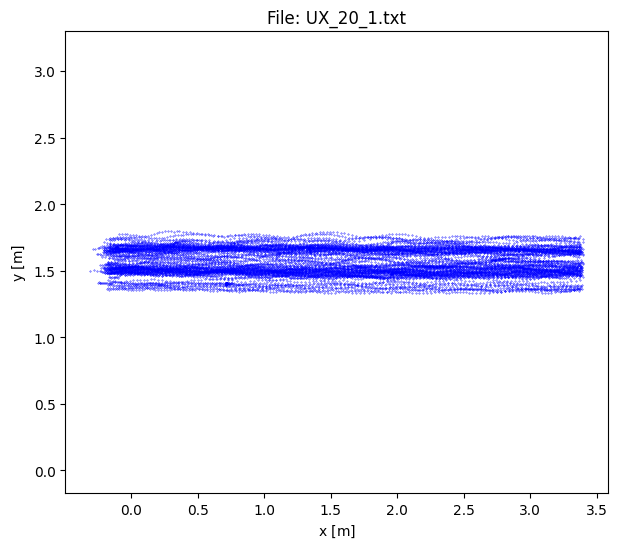

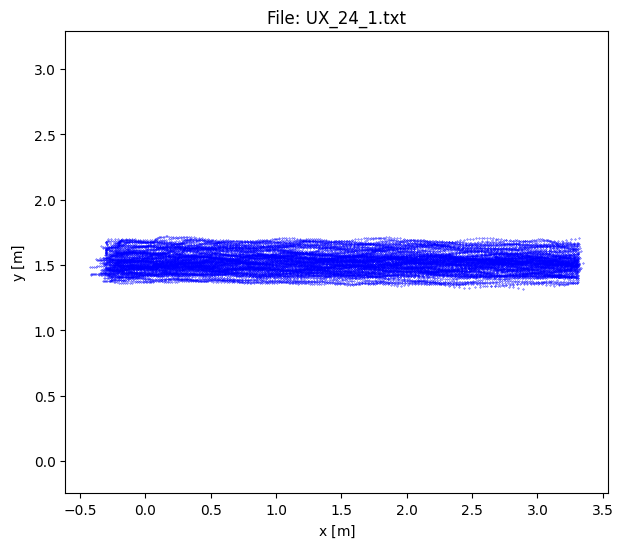

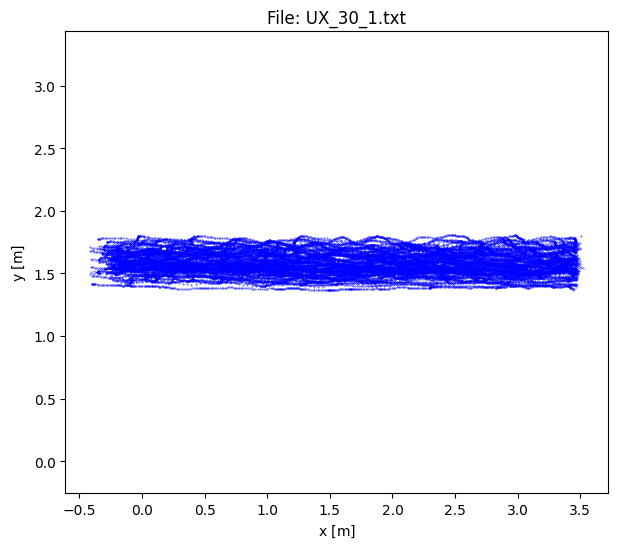

In [3]:
import matplotlib.pyplot as plt

dic_traj_raw = {}

for file in files_traj_raw:
    # read the raw trajectories
    data_traj_raw = pd.read_csv(
        path_traj_raw + "/" + file,
        comment="#",
        delimiter="\t",
        names=["ID", "frame", "x(m)", "y(m)", "z(m)"],
    )

    # save the raw trajectories in a dictionary
    dic_traj_raw[file] = data_traj_raw

    # plot the raw trajectories
    fig = plt.figure(figsize=(7, 6))
    plt.plot(data_traj_raw["x(m)"], data_traj_raw["y(m)"], "bo", markersize=0.3)

    plt.title(f"File: {file}")
    plt.xlabel(r"$\rm x~[m]$")
    plt.ylabel(r"$\rm y~[m]$")
    plt.axis("equal")
    plt.show()

### Apply the transformation additional

First, we need to apply the proper transformation (i.e., convert the unit of the x and y values from centimeter to meter, shift, rotate). We store the transformation data for the available single-file movement datasets in the data class, [experiments.py](../helper/experiments.py), as attributes along with other data required for the analysis (the required attributes documented inside [experiments.py](../helper/experiments.py)). 

> **NOTE:** the trajectories (x and y positions) of the pedestrians should be vertical along the x-axis and starting from x=0.

> **NOTE:** the new transformation data can be saved as an object in the data class [experiments.py](../helper/experiments.py), as the following example:

```py
    "gender_palestine_Subaih": ExperimentData(
        link_data="https://doi.org/10.34735/ped.2018.5",
        shift_x=0,
        shift_y=0,
        unit=1,
        Min=0,
        Max=3.14,
        fps=25,
        length=3.14,
        circumference=3.14,
        camera_capture=1
    )
``` 

or choose one of the stored objects:

In [4]:
from single_file_movement_analysis.experiments import EXPERIMENTS

# the key of the experiment (object from class data)
exp_key = "gender_palestine_Subaih"
e = EXPERIMENTS[exp_key]

retrieve the following attributes required for the transformation:
- ```min```: min boundary of the straight area (measurement area) (if applicable).
- ```max```: max boundary of the straight area (measurement area) (if applicable).
- ```unit```: 100 if data are in cm. Otherwise 1.

In [5]:
min = e.Min
max = e.Max
unit = e.unit

Now, apply the transformation additional function to modify the trajectory data:

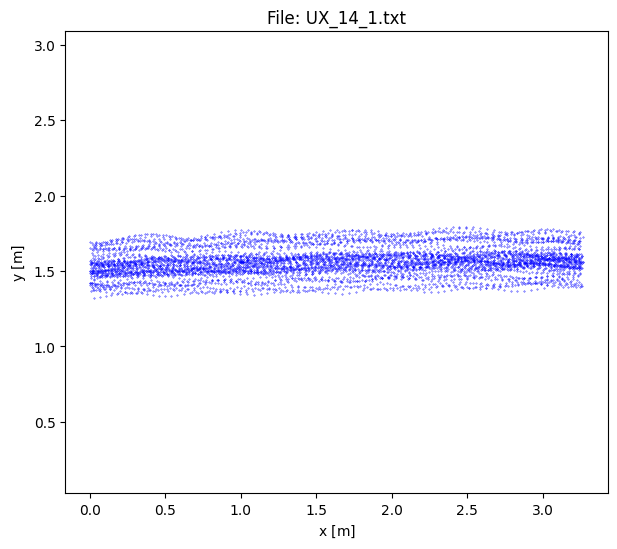

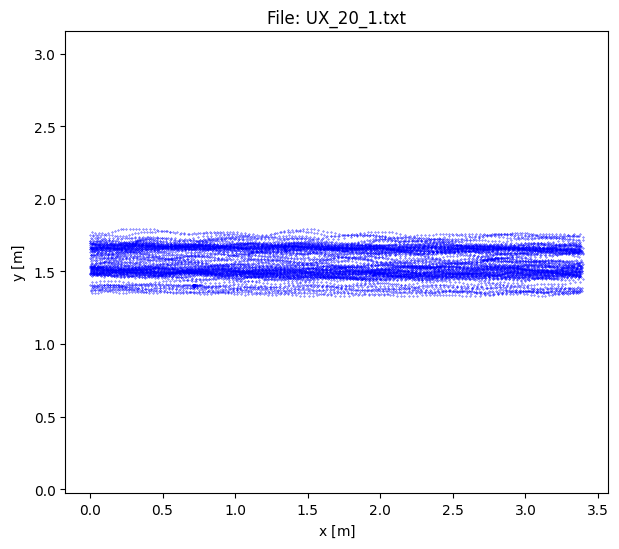

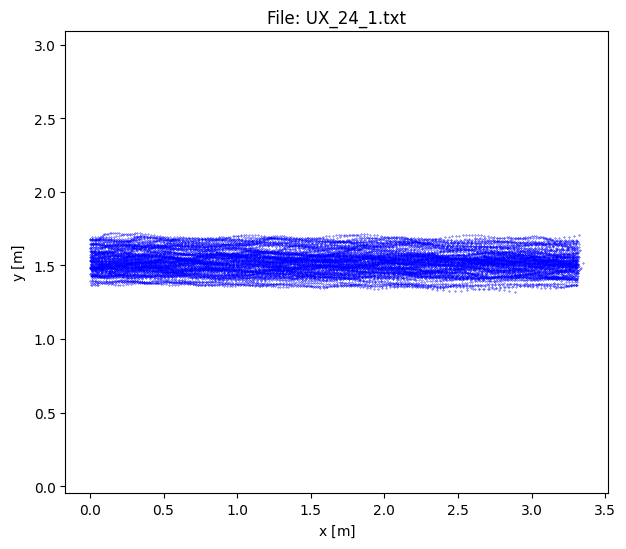

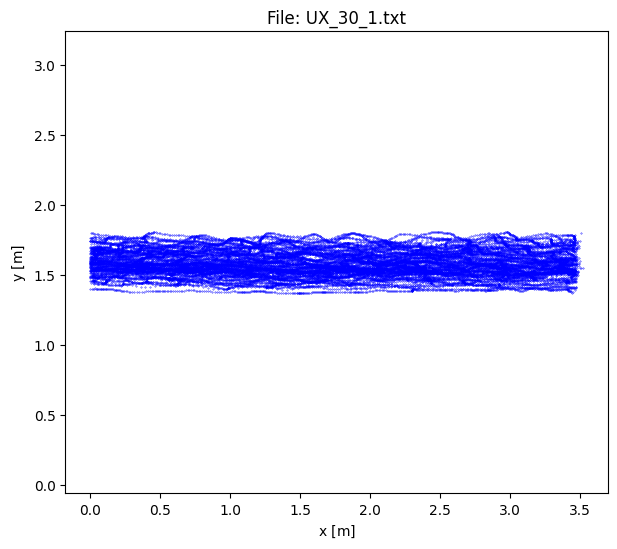

In [6]:
from single_file_movement_analysis.helper import process_data

dict_transformation_additional = {}

for key in dic_traj_raw.keys():
    data_traj_raw = dic_traj_raw[key]
    x_y_transformed = process_data(data_traj_raw[["x(m)", "y(m)"]].to_numpy(), exp_key)
    data_traj_tranformed = data_traj_raw.copy()
    data_traj_tranformed[["x(m)", "y(m)"]] = pd.DataFrame(
        x_y_transformed, columns=["x(m)", "y(m)"]
    )

    if (min is not None) and (
        max is not None
    ):  # data inside measurement area (unique for each experiment)
        data_traj_tranformed = data_traj_tranformed[
            ((data_traj_tranformed["x(m)"] / unit) >= min)
            & ((data_traj_tranformed["y(m)"] / unit) <= max)
        ]

    dict_transformation_additional[key] = data_traj_tranformed

    # plot the transformed trajectories
    fig = plt.figure(figsize=(7, 6))
    plt.plot(
        data_traj_tranformed["x(m)"], data_traj_tranformed["y(m)"], "bo", markersize=0.3
    )

    plt.title(f"File: {key}")
    plt.xlabel(r"$\rm x~[m]$")
    plt.ylabel(r"$\rm y~[m]$")
    plt.axis("equal")
    plt.show()

### Plot the space-time relation

To plot the space-time relation, we need to plot the x-position values from the transformed trajectories data of pedestrians as follows:

First, retrieve the following experiments' attributes:
- ```corridor_length```: length of the whole corridor (oval circumference).
- ```fps```: number of frames per second that the camera captures.

In [7]:
corridor_length = e.circumference
fps = e.fps

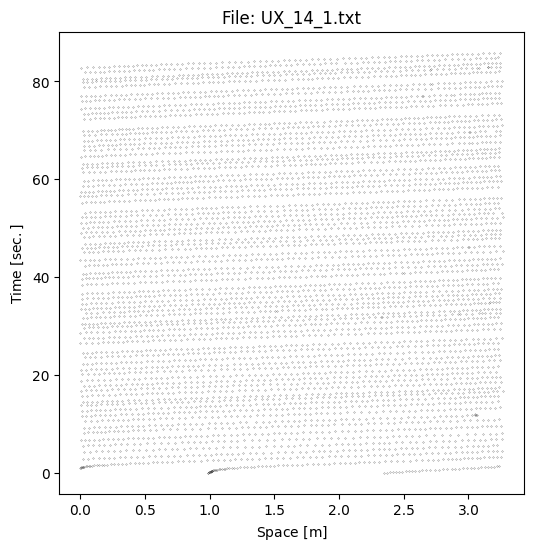

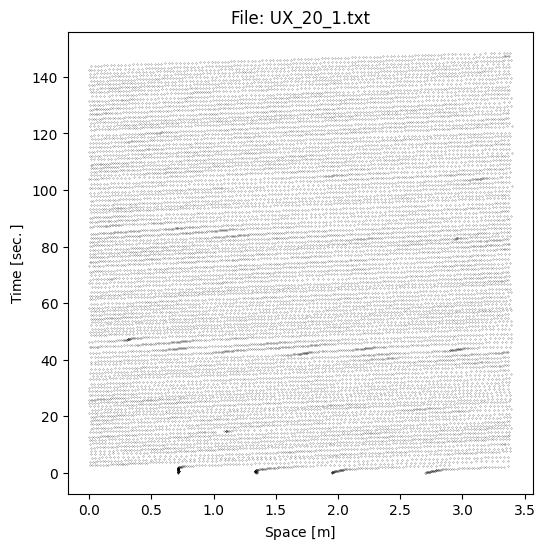

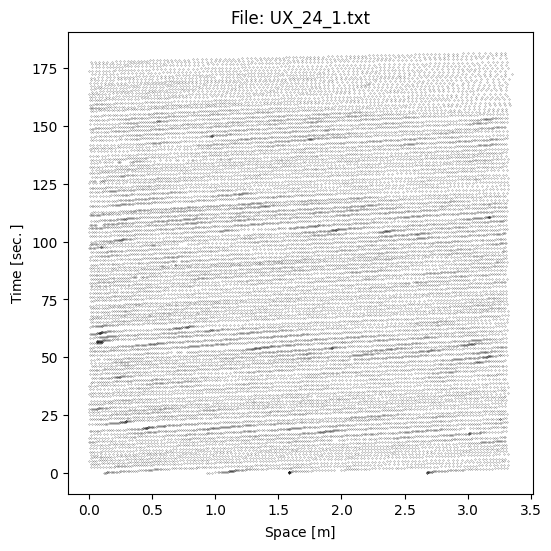

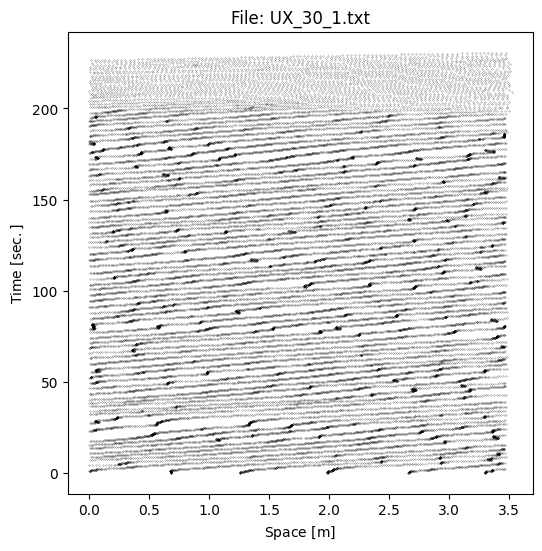

In [8]:
for key in dict_transformation_additional.keys():
    fig = plt.figure(figsize=(6, 6))

    data = dict_transformation_additional[key]
    for ped_id in set(data["ID"]):
        # Take only the trajectory for one person
        p_data = data.loc[data["ID"] == ped_id]
        plt.scatter(
            p_data["x(m)"],
            p_data["frame"] / fps,
            s=0.1,
            edgecolors="black",
            facecolors="black",
            marker=".",
        )

    plt.title(f"File: {key}")
    plt.xlabel(r"Space [$\rm m$]")
    plt.ylabel(r"Time [$\rm sec.$]")
    plt.show()

### Calculate the speed and density of the pedestrians

Here we calculate the individual instantaneous speed and the 1D Voronoi density for each pedestrian over time frames.

First, we define the arguments required for the calculations:
- ```camera_capture```: top-view, or side-view camera.
- ```delta_t```: the time constant to calculate the speed.

In [9]:
camera_capture = e.camera_capture
delta_t = 0.4

then, we apply the function  ```calculate_speed_density_headway(...)``` to calculate the speed, density, and headway of each pedestrian:

In [10]:
from single_file_movement_analysis.helper import calculate_speed_density_headway

dic_speed_density_headway = {}

for key in dict_transformation_additional.keys():
    data = dict_transformation_additional[key]
    new_data = np.array(data[["ID", "frame", "x(m)", "y(m)", "z(m)"]])
    result = calculate_speed_density_headway(
        new_data, fps, corridor_length, camera_capture, delta_t
    )
    data_speed_density_headway = pd.DataFrame(
        result,
        columns=[
            "ID",
            "frame",
            "x(m)",
            "y(m)",
            "z(m)",
            "speed(m/s)",
            "headway(s)",
            "density(1/m)",
        ],
    )

    dic_speed_density_headway[key] = data_speed_density_headway

INFO:	The number of the pedestrians is small = 1
INFO:	The number of the pedestrians is small = 1
INFO:	The number of the pedestrians is small = 1
INFO:	The number of the pedestrians is small = 1
INFO:	The number of the pedestrians is small = 1
INFO:	The number of the pedestrians is small = 1
INFO:	The number of the pedestrians is small = 1
INFO:	The number of the pedestrians is small = 1
INFO:	The number of the pedestrians is small = 1
INFO:	The number of the pedestrians is small = 1
INFO:	The number of the pedestrians is small = 1
INFO:	The number of the pedestrians is small = 1
INFO:	The number of the pedestrians is small = 1
INFO:	The number of the pedestrians is small = 1
INFO:	The number of the pedestrians is small = 1
INFO:	The number of the pedestrians is small = 1
INFO:	The number of the pedestrians is small = 1
INFO:	The number of the pedestrians is small = 1
INFO:	The number of the pedestrians is small = 1
INFO:	The number of the pedestrians is small = 1
INFO:	The number of 

### Choose the steady state

In the single-file movement experiments, pedestrian movement can be categorized into three states: transit states at the beginning and end of the experiment, where pedestrians increase and decrease their speed over time, respectively, and a steady state where pedestrians' speed remains stable over time.

In this step, we need to select the time instances for the steady state to then plot the relations, such as density-speed and headway-speed.

> **NOTE:** Skip the 'Choose the steady state' section if you intend to apply the analysis to all states of pedestrian movement.

First, plot the time-speed/density relation:

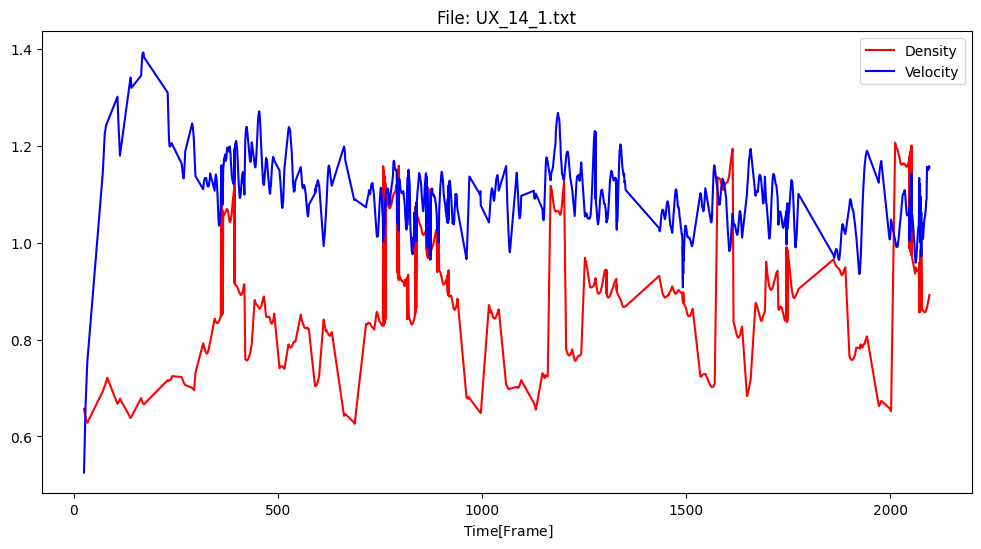

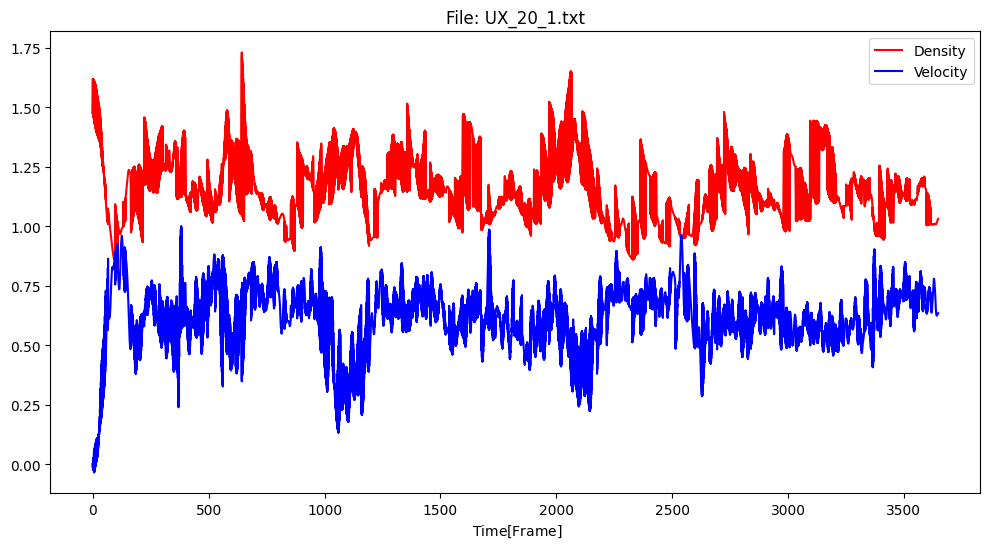

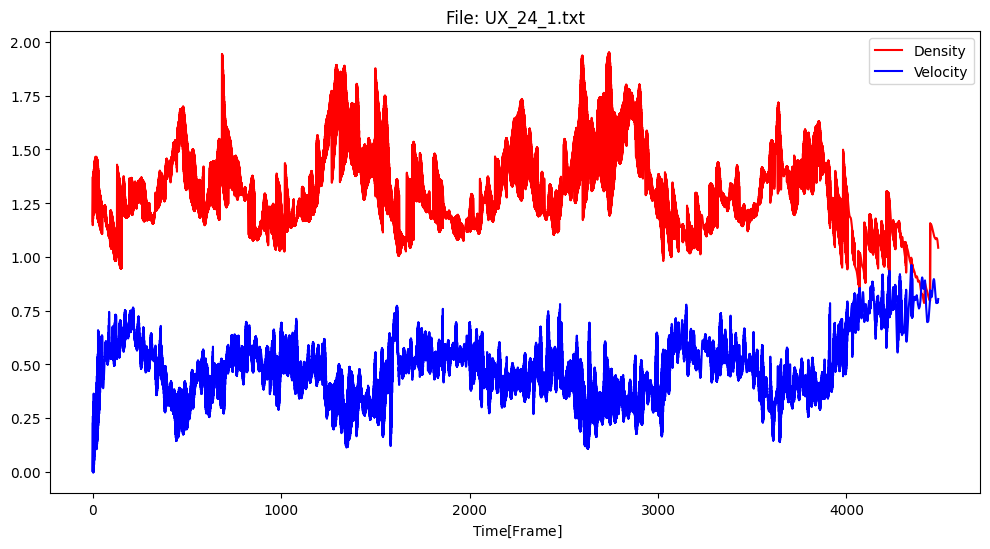

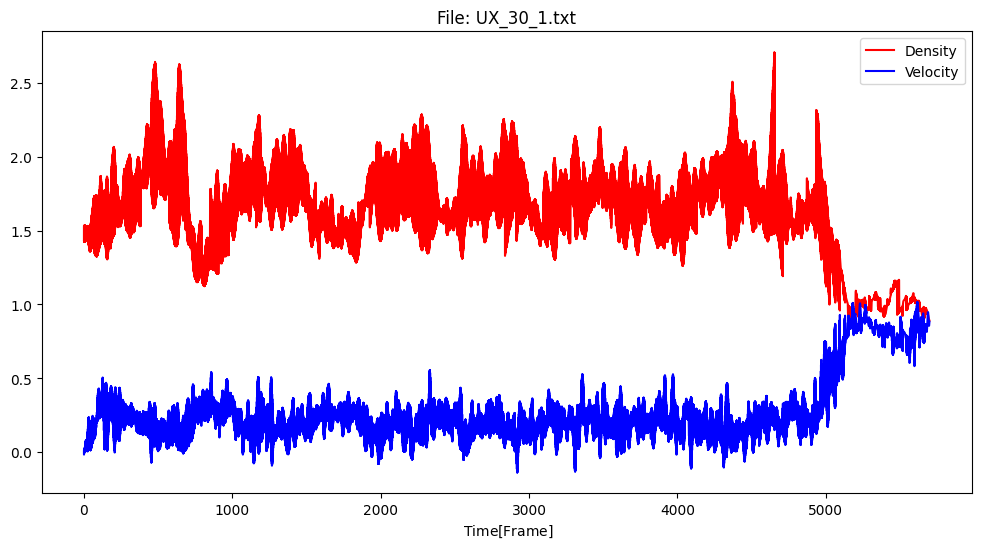

In [11]:
for key in dic_speed_density_headway.keys():
    rho_vel_head_data = dic_speed_density_headway[key]

    fig = plt.figure(figsize=(12, 6))
    plt.plot(
        rho_vel_head_data["frame"],
        rho_vel_head_data["density(1/m)"],
        "r-",
        label="Density",
    )
    plt.plot(
        rho_vel_head_data["frame"],
        rho_vel_head_data["speed(m/s)"],
        "b-",
        label="Velocity",
    )

    plt.title(f"File: {key}")
    plt.xlabel(r" $\rm Time[Frame]$")
    plt.legend()
    plt.show()

let's use the experiment file "UX_14_1.txt" to manually select the start and end frames of the steady state:

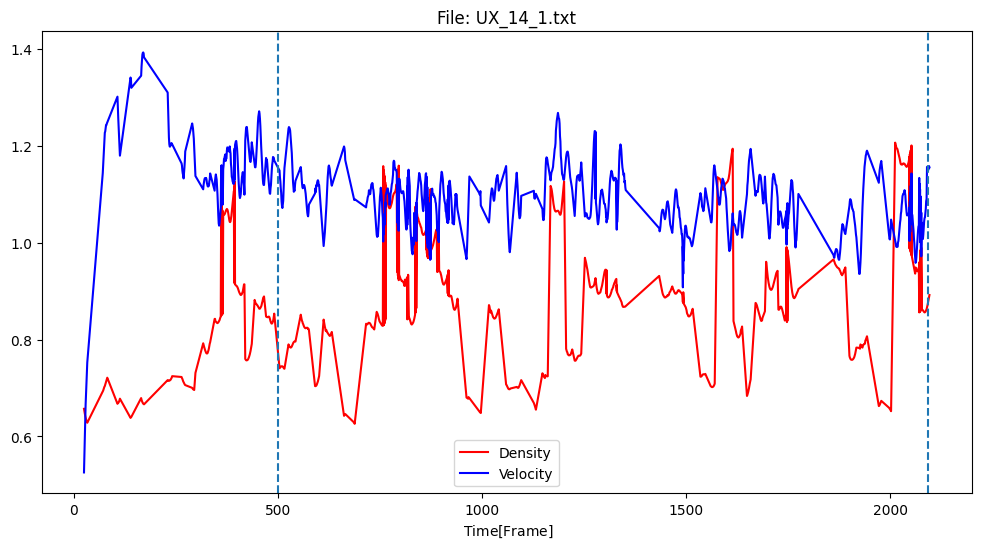

In [12]:
key = "UX_14_1.txt"
st = 500  # start time frame of the steady state
en = 2092  # end time frame of the steady state

steady_state_data = dic_speed_density_headway[key]

fig = plt.figure(figsize=(12, 6))
plt.plot(
    steady_state_data["frame"], steady_state_data["density(1/m)"], "r-", label="Density"
)
plt.plot(
    steady_state_data["frame"], steady_state_data["speed(m/s)"], "b-", label="Velocity"
)

plt.title(f"File: {key}")
plt.xlabel(r" $\rm Time[Frame]$")
plt.legend()

plt.axvline(x=st, linestyle="--")
plt.axvline(x=en, linestyle="--")
plt.show()

save the start and end frames of all experiments' steady states in the following argument:

In [13]:
starts = [500, 250, 500, 1000]
ends = [2092, 3637, 3000, 4300]

extract the data corresponding to the steady state from all the experiments' data:

In [14]:
from single_file_movement_analysis.helper import extract_steady_state

dic_speed_density_headway_steady_state = {}

for key, start, end in zip(dic_speed_density_headway.keys(), starts, ends):
    steady_state_data = extract_steady_state(
        dic_speed_density_headway[key].to_numpy(), start, end
    )
    dic_speed_density_headway_steady_state[key] = pd.DataFrame(
        steady_state_data,
        columns=[
            "ID",
            "frame",
            "x(m)",
            "y(m)",
            "t(s)",
            "speed(m/s)",
            "headway(s)",
            "density(1/m)",
        ],
    )

### Plot the fundamental diagram (density-speed)

Plot the fundamental diagram relation (density-speed), customizing the figure labels and adding the experiment name as the figure title:

In [15]:
labels = ["UX=14", "UX=20", "UX=24", "UX=30"]
experiment_name = "Palestine_Subaih2019"

then, plot:

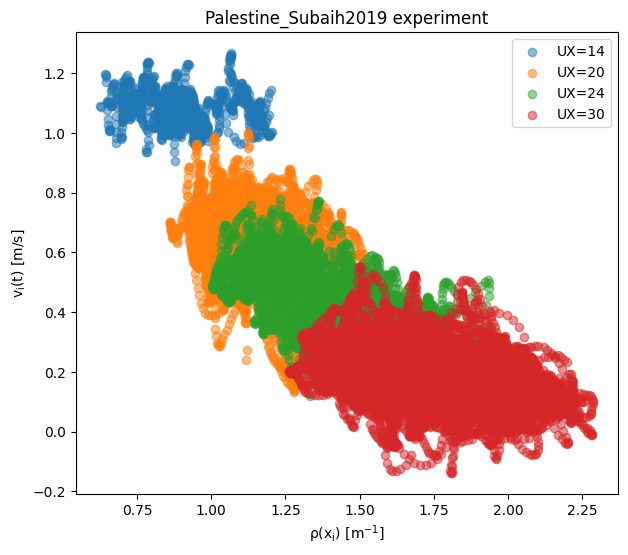

In [16]:
fig = plt.figure(figsize=(7, 6))

for key, label in zip(dic_speed_density_headway_steady_state.keys(), labels):
    data = dic_speed_density_headway_steady_state[key]
    plt.scatter(data["density(1/m)"], data["speed(m/s)"], label=label, alpha=0.5)

plt.xlabel(r"$\rm \rho(x_{i})~[m^{-1}]$")
plt.ylabel(r"$\rm v_{i}(t)~[m/s]$")
plt.legend()
plt.title(f"{experiment_name} experiment")
plt.show()

### Plot the headway-speed relation

and to plot the headway-speed relation:

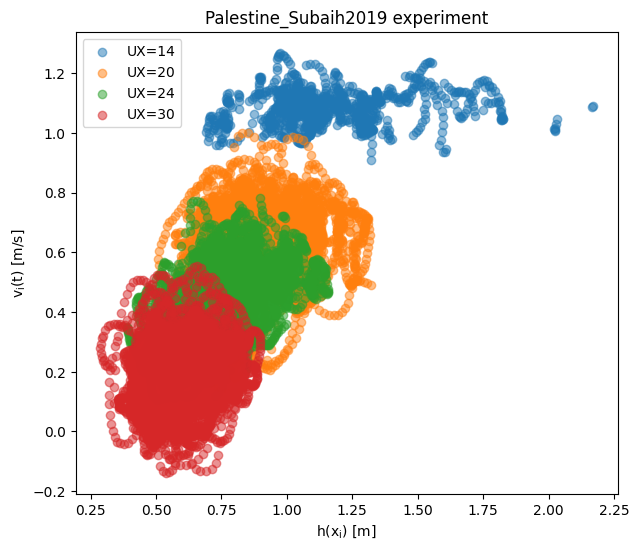

In [17]:
fig = plt.figure(figsize=(7, 6))

for key, label in zip(dic_speed_density_headway_steady_state.keys(), labels):
    data = dic_speed_density_headway_steady_state[key]
    plt.scatter(data["headway(s)"], data["speed(m/s)"], label=label, alpha=0.5)

plt.xlabel(r"$\rm h(x_{i})~[m]$")
plt.ylabel(r"$\rm v_{i}(t)~[m/s]$")
plt.legend()
plt.title(f"{experiment_name} experiment")
plt.show()

### Save the data into files

Here are the codes to save all results in .csv files for the following:
- Trajectory transformation additional data
- Trajectory transformation straight data
- Density, speed, and headway data

First, choose the path of the directory to save the outputs:

In [18]:
path_output = "../notebooks/demo_data/genderMixedAlternating_palestine_subaih2019"

Then, save the data of transformation additional:

In [19]:
import os

for key in dict_transformation_additional.keys():
    data = dict_transformation_additional[key]
    if not os.path.exists(path_output + "/traj/02_transformation_additional/"):
        os.makedirs(path_output + "/traj/02_transformation_additional/")
    data.to_csv(
        path_output + "/traj/02_transformation_additional/" + key, sep="\t", index=False
    )

save the caclulated movement quantities (density,speed, headway):

In [20]:
for key in dic_speed_density_headway.keys():
    data = dic_speed_density_headway[key]
    if not os.path.exists(path_output + "/rho_vel_headway/"):
        os.makedirs(path_output + "/rho_vel_headway/")
    data.to_csv(path_output + "/rho_vel_headway/" + key, sep="\t", index=False)

save the caclulated movement quantities (density,speed, headway) in the 
steady state:

In [21]:
for key in dic_speed_density_headway_steady_state.keys():
    data = dic_speed_density_headway_steady_state[key]
    if not os.path.exists(path_output + "/rho_vel_headway/steady_state_data/"):
        os.makedirs(path_output + "/rho_vel_headway/steady_state_data/")
    data.to_csv(
        path_output + "/rho_vel_headway/steady_state_data/" + key, sep="\t", index=False
    )